## Import modules

In [34]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path
%matplotlib inline
def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims

## Specify experiment directory

In [35]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture/20190216_TNR580_DiO_VGlut647/TIFs_analyse' #master folder
protein="TNR" #TNR,Agg,WFA,HABP

In [36]:
results = {"filename":[],
           "ecmchannelno":[],"diochannelno":[],"synapsechannelno":[],"noblock_controldir":[],
           "Soma mask from synapse channel":[],
           "Neurites mask from synapse channel":[],
           "Manual mask from matlab GUI":[],
           "exp condition":[],
           "ECM raw intensity, unmasked":[],
           "funcat raw intensity, unmasked":[],
           "Synapse raw intensity, unmasked":[],
           "ECM intensity: unmasked, divded by unblocked condition":[],
           "ECM mean intensity: soma only":[],
           "ECM mean intensity: soma only, divided by unblocked":[],
           "ECM mean intensity: neurites only":[],
           "ECM mean intensity: neurites only, divided by unblocked":[],
           "ECM mean intensity: matlab manual mask only":[],
           "ECM mean intensity: matlab manual mask only, divided by unblocked":[],
           "Synapse mean intensity: soma only":[],
           "Synapse mean intensity: neurites only":[],
           "Synapse mean intensity: matlab manual mask only":[],
           "funcat mean intensity: soma only":[],
           "funcat mean intensity: neurites only":[],
           "funcat mean intensity: matlab manual mask only":[],
           "Number of synapse spots in soma mask":[],
           "Number of synapse spots in neurites mask":[],
           "Number of synapse spots in matlab manual mask":[],
           "Number of funcat spots in soma mask":[],
           "Number of funcat spots in neurites mask":[],
           "Number of funcat spots in matlab manual mask":[],
           "ECM mean intensity after bg subtraction: soma only":[],
           "ECM mean intensity after bg subtraction: soma only, divided by unblocked":[],
           "ECM mean intensity after bg subtraction: neurites only":[],
           "ECM mean intensity after bg subtraction: neurites only, divided by unblocked":[],
           "ECM mean intensity after bg subtraction: matlab manual mask only":[],
           "ECM mean intensity after bg subtraction: matlab manual mask only, divided by unblocked":[],
           "Synapse mean intensity after bg subtraction: soma only":[],
           "Synapse mean intensity after bg subtraction: neurites only":[],
           "Synapse mean intensity after bg subtraction: matlab manual mask only":[],
           "Number of synapse spots in soma mask after bg subtraction":[],
           "Number of synapse spots in neurites mask after bg subtraction":[],
           "Number of synapse spots in matlab manual mask after bg subtraction":[],
           "Number of funcat spots in soma mask after bg subtraction":[],
           "Number of funcat spots in neurites mask after bg subtraction":[],
           "Number of funcat spots in matlab manual mask after bg subtraction":[],
          "Number of funcat spots in matlab manual mask after bg subtraction":[],
          "Manual synapse spots mask":[]}
          
histogram_results={"filename":[],"exp condition":[],
                   "ECM raw intensity- Flattened histogram":[],
                   "funcat raw intensity- Flattened histogram":[],
                   "Synapse raw intensity- Flattened histogram":[]}
regionprops_results={"filename":[],
                     "exp condition":[],
                     "Synapse colour - regionprops soma":[],
                     "Synapse colour - regionprops neurites":[]}

independent_ecm_results={"filename":[],
                     "exp condition":[],
                     "regionprops auto masking":[],
                     "regionprops matlab mask":[],
                        "distance from nearest dapi border":[]}

ecm_distribution_around_synapses={"filename":[],
                                  "exp condition":[],
                                  "ecm_around_single_spot":[]
                                 }

path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if "_analyse" in str(filelist[i]):
        if ("Focus" in str(filelist[i]))==False:
            if (protein in str(filelist[i]))==True:
                if filelist[i].endswith(".tif"): 
                    if str(filelist[i][:-12]) not in str(results["filename"]):

                        results["filename"].append(filelist[i][:-12])
                        histogram_results["filename"].append(filelist[i][:-12])
                        regionprops_results["filename"].append(filelist[i][:-12])
                        independent_ecm_results["filename"].append(filelist[i][:-12])

                        results["exp condition"].append(filelist[i][:-12].split('/')[-2])
                        histogram_results["exp condition"].append(filelist[i][:-12].split('/')[-2])
                        regionprops_results["exp condition"].append(filelist[i][:-12].split('/')[-2])
                        independent_ecm_results["exp condition"].append(filelist[i][:-12].split('/')[-2])
             
                        channeldir="/".join(filelist[i][:-12].split("/")[:-2])
                        exec(open(channeldir+"/channels.txt").read())
                        results["ecmchannelno"].append(ecmchannelno)
                        results["diochannelno"].append(diochannelno)
                        results["synapsechannelno"].append(synapsechannelno)
                        positivecontrolcheck=Path(channeldir+"/Ctrl_NoBlocking")
                        if positivecontrolcheck.exists():
                            results["noblock_controldir"].append(channeldir+"/Ctrl_NoBlocking")                

<a id='loadingprocessinganalysing'></a> 
## Loading, processing and batch analyzing the images
**Let's start by loading a random image and looking at the ECM channel:**

Image name: TIF_imp\01_001_ExpControl
Experimental condition: Ctrl_NoBlocking


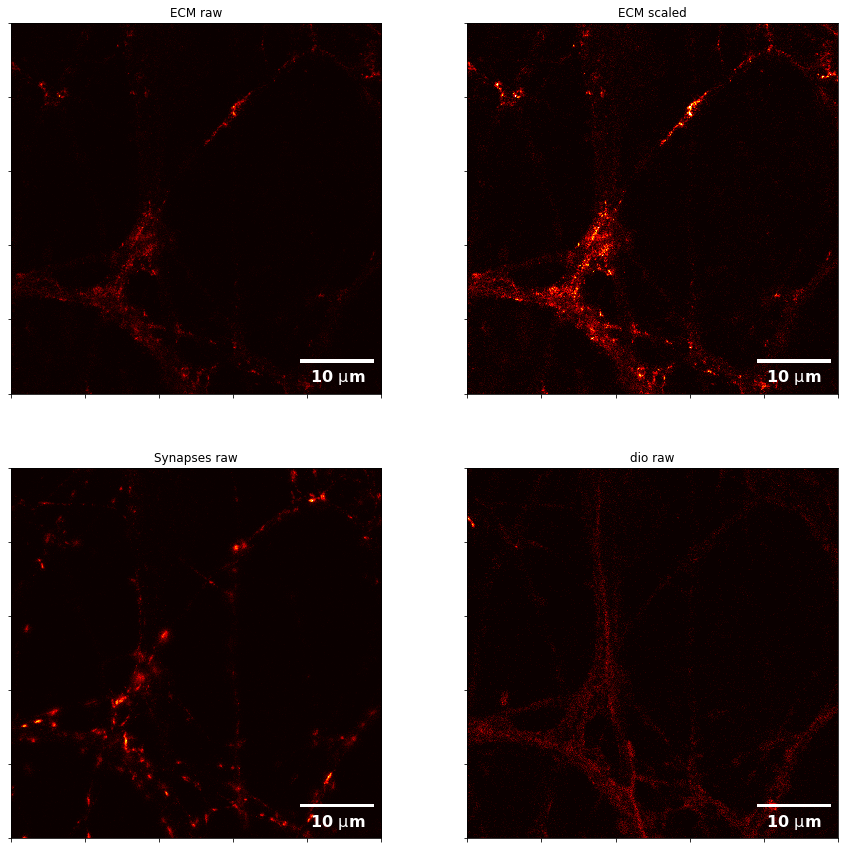

In [37]:
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
dio_channel_no=results["diochannelno"][randomno]
synapse_channel_no=results["synapsechannelno"][randomno]

ecm_image_name=results["filename"][randomno]+" Ch"+str(ecm_channel_no)+" {0}.tif"
dio_image_name=results["filename"][randomno]+" Ch"+str(dio_channel_no)+" {0}.tif"
synapse_image_name=results["filename"][randomno]+" Ch"+str(synapse_channel_no)+" {0}.tif"


print("Image name:",results["filename"][randomno].split('/')[-1])
print("Experimental condition:",results["exp condition"][randomno])
ecm_image=pims.open(ecm_image_name)[0]
dio_image=pims.open(dio_image_name)[0]
synapse_image=pims.open(synapse_image_name)[0]

    
figure=plt.figure(figsize=(15,15))
figure.add_subplot(221)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
figure.add_subplot(222)
plt.imshow(ecm_image,interpolation='none',cmap='hot',vmin=3*np.min(ecm_image),vmax=0.4*np.max(ecm_image))
plt.title('ECM scaled')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)
figure.add_subplot(223)
plt.imshow(synapse_image,interpolation='none',cmap='hot')
plt.title('Synapses raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)
figure.add_subplot(224)
plt.imshow(dio_image,interpolation='none',cmap='hot')
plt.title('dio raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)



## Deconvolution with RL algorithm attempt

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure
from scipy import ndimage, signal
from flowdec import data as fd_data
from flowdec import restoration as fd_restoration

# Load "Purkinje Neuron" dataset downsampled from 200x1024x1024 to 50x256x256
# See: http://www.cellimagelibrary.org/images/CCDB_2
actual = ecm_image
# actual.shape = (50, 256, 256)

# Create a gaussian kernel that will be used to blur the original acquisition
kernel = np.zeros_like(actual)
for offset in [0, 1]:
    kernel[tuple((np.array(kernel.shape) - offset) // 2)] = 1
kernel = ndimage.gaussian_filter(kernel, sigma=1.)
# kernel.shape = (50, 256, 256)

# Convolve the original image with our fake PSF
data = signal.fftconvolve(actual, kernel, mode='same')
# data.shape = (50, 256, 256)

# Run the deconvolution process and note that deconvolution initialization is best kept separate from 
# execution since the "initialize" operation corresponds to creating a TensorFlow graph, which is a 
# relatively expensive operation and should not be repeated across multiple executions
algo = fd_restoration.RichardsonLucyDeconvolver(data.ndim).initialize()
res = algo.run(fd_data.Acquisition(data=data, kernel=kernel), niter=30).data

fig, axs = plt.subplots(1, 3)
axs = axs.ravel()
fig.set_size_inches(18, 12)
center = tuple([slice(None), slice(10, -10), slice(10, -10)])
titles = ['Original Image', 'Blurred Image', 'Reconstructed Image']
for i, d in enumerate([actual, data, res]):
    img = exposure.adjust_gamma(d[center].max(axis=0), gamma=.2)
    axs[i].imshow(img, cmap='Spectral_r')
    axs[i].set_title(titles[i])
    axs[i].axis('off')

In [ ]:
len(results["filename"])

Image name: TIF_imp\05_001_ExpControl
Experimental condition: 12hr_Bic


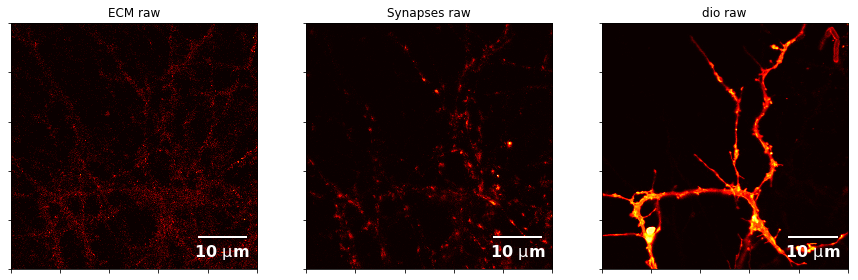

In [28]:
randomno=1
ecm_channel_no=results["ecmchannelno"][randomno]
dio_channel_no=results["diochannelno"][randomno]
synapse_channel_no=results["synapsechannelno"][randomno]

ecm_image_name=results["filename"][randomno]+" Ch"+str(ecm_channel_no)+" {0}.tif"
dio_image_name=results["filename"][randomno]+" Ch"+str(dio_channel_no)+" {0}.tif"
synapse_image_name=results["filename"][randomno]+" Ch"+str(synapse_channel_no)+" {0}.tif"


print("Image name:",results["filename"][randomno].split('/')[-1])
print("Experimental condition:",results["exp condition"][randomno])
ecm_image=pims.open(ecm_image_name)[0]
dio_image=pims.open(dio_image_name)[0]
synapse_image=pims.open(synapse_image_name)[0]

    
figure=plt.figure(figsize=(15,15))
figure.add_subplot(131)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
figure.add_subplot(132)

plt.imshow(synapse_image,interpolation='none',cmap='hot')
plt.title('Synapses raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)
figure.add_subplot(133)
plt.imshow(dio_image,interpolation='none',cmap='hot')
plt.title('dio raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)




In [38]:
for i in range(0,len(results["filename"])):
    results["Manual synapse spots mask"].append(np.nan)

### Find synapse spots

In [11]:
import ipywidgets as widgets
from ipywidgets import interact
first=0

#load first image
synapse_channel_no=results["synapsechannelno"][first]
synapse_image_name=results["filename"][first]+" Ch"+str(synapse_channel_no)+" {0}.tif"
synapse_image=pims.open(synapse_image_name)[0]
synapse_spots=deepcopy(synapse_image)
synapse_spots=ndi.median_filter(synapse_spots,size=5)

lower_man_threshold=np.min(synapse_spots)
upper_man_threshold=np.max(synapse_spots)

def f(Threshold,Manual_Threshold,Open,Close,Image_no):
    
    ii=Image_no
    synapse_channel_no=results["synapsechannelno"][ii]
    synapse_image_name=results["filename"][ii]+" Ch"+str(synapse_channel_no)+" {0}.tif"
    synapse_image=pims.open(synapse_image_name)[0]
    synapse_spots=deepcopy(synapse_image)
    lower_man_threshold=np.min(synapse_spots)
    upper_man_threshold=np.max(synapse_spots)

    if Threshold=="Li":
        synapse_image_threshold=threshold_li(synapse_image)      
    if Threshold=="Otsu":
        synapse_image_threshold=threshold_otsu(synapse_image)
    if Threshold=="Manual":
        synapse_image_threshold=Manual_Threshold
    
    synapse_spots[synapse_spots<synapse_image_threshold]=0
    synapse_spots=ndi.binary_opening(synapse_spots,iterations=Open)
    synapse_spots=ndi.binary_closing(synapse_spots,iterations=Close)
    results["Manual synapse spots mask"][ii]=synapse_spots
    plt.figure(figsize=(10,10))
    plt.imshow(synapse_spots)
    plt.imshow(synapse_image,alpha=0.5,cmap='inferno')
    

#widgets
Threshold=widgets.Dropdown(options=["Li","Otsu","Manual"])
Manual_Threshold=widgets.IntSlider(min=lower_man_threshold,max=upper_man_threshold,step=1,value=lower_man_threshold)
Open=widgets.IntText(min=0,max=20,step=1,value=1)
Close=widgets.IntText(min=0,max=20,step=1,value=1)
Image_no=widgets.IntText(min=0,max=len(results["filename"]),value=0)

w=interact(f,Threshold=Threshold,Manual_Threshold=Manual_Threshold,Open=Open,Close=Close,
           Image_no=Image_no)




interactive(children=(Dropdown(description='Threshold', options=('Li', 'Otsu', 'Manual'), value='Li'), IntSlid…

## Backup the manual masks that were made

In [ ]:
for mask in range(0,len(results["filename"])):
    #print(mask)
    if np.isnan(results["Manual synapse spots mask"][mask]).any()==False:
        np.save((str(results["filename"][mask])+'_manualsynmask.npy'), results["Manual synapse spots mask"][mask])
        print(results["filename"][mask])

## load manual synapse spots masks

In [9]:
for mask in range(0,len(results["filename"])):
    print(results["filename"][mask])
    results["Manual synapse spots mask"][mask]=np.load((str(results["filename"][mask])+'_manualsynmask.npy'))
    

/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture_ClickChemistry/20181224_Click/STED BIN/TIF_imp/TNR_analyse/tnrhpg/06_001_ExpControl


FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture_ClickChemistry/20181224_Click/STED BIN/TIF_imp/TNR_analyse/tnrhpg/06_001_ExpControl_manualsynmask.npy'

### If needed: to quickly make automatic synapse spots (this is bad)

In [15]:
results["filename"][ii]

'/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture/20190216_TNR580_DiO_VGlut647/TIFs_analyse/Ctrl_NoBlocking/TIF_imp\\02_003_ExpControl'

In [13]:
synapse_image_name

'/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture/20190216_TNR580_DiO_VGlut647/TIFs_analyse/Ctrl_NoBlocking/TIF_imp\\02_003_ExpControl Ch1 {0}.tif'

In [39]:
for ii in range(0,len(results["filename"])):
    synapse_channel_no=results["synapsechannelno"][ii]
    synapse_image_name=results["filename"][ii]+" Ch"+str(synapse_channel_no)+" {0}.tif"
    synapse_image=pims.open(synapse_image_name)[0]
    synapse_spots=deepcopy(synapse_image)

    #synapse_image_threshold=threshold_otsu(synapse_image)
    synapse_image_threshold=11
    
    synapse_spots[synapse_spots<synapse_image_threshold]=0
    synapse_spots=ndi.binary_opening(synapse_spots,iterations=10)
    synapse_spots=ndi.binary_closing(synapse_spots,iterations=10)
    results["Manual synapse spots mask"][ii]=synapse_spots


Text(0.5, 1.0, 'ECM raw image')

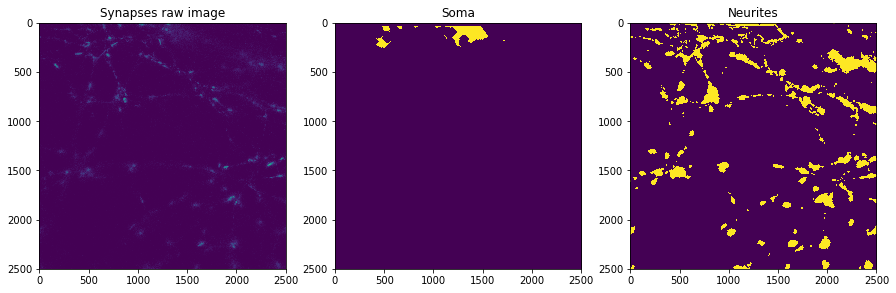

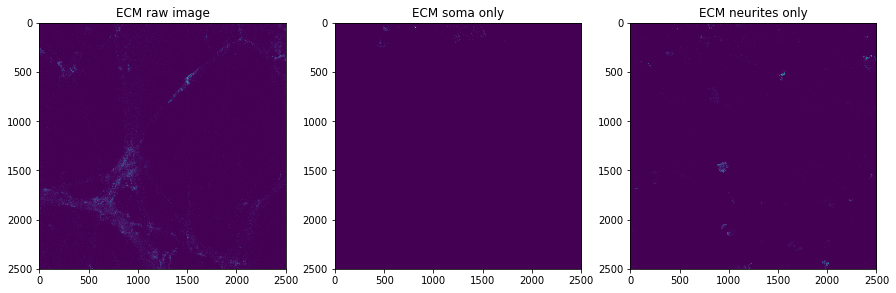

In [40]:
ecm_image_threshold=threshold_li(ecm_image)
ecm_image_thresholded=deepcopy(ecm_image)
ecm_image_thresholded[ecm_image_thresholded<ecm_image_threshold]=0

def makemask(synapse_image):
    #li thresholding
    synapse_image_threshold=threshold_li(synapse_image)
    synapse_image_thresholded=deepcopy(synapse_image)
    synapse_image_thresholded[synapse_image_thresholded<synapse_image_threshold]=0
    #find soma + some morphological operations
    synapse_labeled_mask, cc_num = ndi.label(synapse_image_thresholded)
    synapse_largest_cc_mask = (synapse_labeled_mask == (np.bincount(synapse_labeled_mask.flat)[1:].argmax() + 1))
    soma_mask=ndi.binary_closing(ndi.gaussian_filter(synapse_largest_cc_mask,sigma=1),iterations=40)
    #some morphological operations on the neurite mask
    neurite_mask=deepcopy(synapse_image_thresholded)
    neurite_mask[neurite_mask>np.percentile(neurite_mask,99.5)]=0
    neurite_mask[soma_mask]=0
    neurite_mask=ndi.gaussian_filter(neurite_mask,sigma=0.5)
    neurite_mask[neurite_mask>0]=1
    neurite_mask=ndi.binary_erosion(neurite_mask,iterations=4)
    neurite_mask=ndi.binary_dilation(neurite_mask,iterations=7)
    neurite_mask=ndi.binary_fill_holes(neurite_mask)
    return(soma_mask,neurite_mask)
    
#make temporary masked images to show what we will keep
ecm_somamasked=deepcopy(ecm_image)
ecm_neuritemasked=deepcopy(ecm_image)
soma_mask,neurite_mask=makemask(synapse_image)
ecm_somamasked[~soma_mask]=0
ecm_neuritemasked[~neurite_mask]=0
    
#show
fig=plt.figure(figsize=(15,15))
fig.add_subplot(131)
plt.imshow(synapse_image)
plt.title('Synapses raw image')
fig.add_subplot(132)
plt.imshow(soma_mask)
plt.title('Soma')
fig.add_subplot(133)
plt.imshow(neurite_mask)
plt.title('Neurites')

fig=plt.figure(figsize=(15,15))
fig.add_subplot(132)
plt.imshow(ecm_somamasked)
plt.title('ECM soma only')
fig.add_subplot(133)
plt.imshow(ecm_neuritemasked)
plt.title('ECM neurites only')
fig.add_subplot(131)
plt.imshow(ecm_image)
plt.title('ECM raw image')

## Make individual spot images

In [33]:
results["filename"][i]

'/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture/20190216_TNR580_DiO_VGlut647/TIFs_analyse/12hr_DMSO/TIF_imp\\02_003_ExpControl'

In [41]:
from skimage.measure import regionprops

#regionprops centroid = center of spot
ecm_distribution_around_synapses={"filename":[],
                                  "exp condition":[],
                                  "ecm_around_single_spot":[],
                                  "ecm_around_single_spot_mean_intensity":[],
                                  "original_synapse_at_single_spot":[],
                                  "mean_intensty_original_synapse":[],
                                  "ecm_around_single_spot bg subtracted":[],
                                  "ecm_around_single_spot_mean_intensity bg subtracted":[],
                                  "original_synapse_at_single_spot bg subtracted":[],
                                  "mean_intensty_original_synapse bg subtracted":[],
                                  "dio_around_single_spot":[],
                                  "dio_around_single_spot_mean_intensity":[],
                                  "dio_around_single_spot bg subtracted":[],
                                  "dio_around_single_spot_mean_intensity bg subtracted":[],
                                 }
for i in range(0,len(results["filename"])):
    #read the image
    ecm_channel_no=results["ecmchannelno"][i]
    ecm_image_name=results["filename"][i]+" Ch"+str(ecm_channel_no)+" {0}.tif"
    ecm_image=pims.open(ecm_image_name)[0]
    synapse_channel_no=results["synapsechannelno"][i]
    synapse_image_name=results["filename"][i]+" Ch"+str(synapse_channel_no)+" {0}.tif"
    synapse_image=pims.open(synapse_image_name)[0]
    dio_channel_no=results["diochannelno"][i]
    dio_image_name=results["filename"][i]+" Ch"+str(dio_channel_no)+" {0}.tif"
    dio_image=pims.open(dio_image_name)[0]
    
    #label connected components in spots mask
    spots_mask=results["Manual synapse spots mask"][i]
    spots_labeled, cc_num=ndi.label(spots_mask)
    #cut out ecm image 4microns around each spot - 200pixels
    print(cc_num)
    regions = regionprops(spots_labeled)
    #fig, ax = plt.subplots(figsize=(10,10))
    #ax.imshow(spots_mask,cmap=plt.cm.gray)
    for props in regions:
        y0, x0 = props.centroid
        #[print(y0,x0)]

        center_of_spot=[0,0]
        center_of_spot[0]=np.round(y0).astype(int)
        center_of_spot[1]=np.round(x0).astype(int)

        #center_of_spot=np.round(ndi.measurements.center_of_mass(ecm_image,labels=spots_labeled,index=spot)).astype(int)

        if (((center_of_spot[1]-50>0) & (center_of_spot[1]+50>0))&((center_of_spot[0]-50>0) & (center_of_spot[0]+50>0))):

            ecm_around_spot=ecm_image[center_of_spot[0]-50:center_of_spot[0]+50,
                  center_of_spot[1]-50:center_of_spot[1]+50]

            original_synapse_at_single_spot=synapse_image[center_of_spot[0]-50:center_of_spot[0]+50,
                  center_of_spot[1]-50:center_of_spot[1]+50]
            
            dio_around_spot=dio_image[center_of_spot[0]-50:center_of_spot[0]+50,
                  center_of_spot[1]-50:center_of_spot[1]+50]

            if ecm_around_spot.shape==(100,100):
                #print("True")
                ecm_distribution_around_synapses["filename"].append(results["filename"][i])
                ecm_distribution_around_synapses["exp condition"].append(results["exp condition"][i])

                mean_intensty_original_synapse=np.mean(original_synapse_at_single_spot)
                ecm_distribution_around_synapses["mean_intensty_original_synapse"].append(mean_intensty_original_synapse)

                ecm_distribution_around_synapses["ecm_around_single_spot"].append(ecm_around_spot)
                ecm_distribution_around_synapses["original_synapse_at_single_spot"].append(original_synapse_at_single_spot)
                ecm_distribution_around_synapses["ecm_around_single_spot_mean_intensity"].append(np.nanmean(ecm_around_spot))
                ecm_distribution_around_synapses["dio_around_single_spot"].append(dio_around_spot)
                ecm_distribution_around_synapses["dio_around_single_spot_mean_intensity"].append(np.nanmean(dio_around_spot))


                #after bg subtraction
                ecm_around_spot_bgsub=np.array(deepcopy(ecm_around_spot))
                ecm_around_spot_bgsub=np.divide(ecm_around_spot_bgsub,255)
                bg_ecm=np.mean(ndi.median_filter(ecm_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(ecm_around_spot_bgsub,size=5))
                ecm_around_spot_bgsub=np.subtract(ecm_around_spot_bgsub,bg_ecm)
                ecm_around_spot_bgsub[ecm_around_spot_bgsub<0]=0

                synapse_around_spot_bgsub=np.array(deepcopy(original_synapse_at_single_spot))
                synapse_around_spot_bgsub=np.divide(synapse_around_spot_bgsub,255)
                bg_synapse=np.mean(ndi.median_filter(synapse_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(synapse_around_spot_bgsub,size=5))
                synapse_around_spot_bgsub=np.subtract(synapse_around_spot_bgsub,bg_synapse)
                synapse_around_spot_bgsub[synapse_around_spot_bgsub<0]=0
                
                dio_around_spot_bgsub=np.array(deepcopy(dio_around_spot))
                dio_around_spot_bgsub=np.divide(dio_around_spot_bgsub,255)
                bg_dio=np.mean(ndi.median_filter(dio_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(dio_around_spot_bgsub,size=5))
                dio_around_spot_bgsub=np.subtract(dio_around_spot_bgsub,bg_dio)
                dio_around_spot_bgsub[dio_around_spot_bgsub<0]=0

                ecm_distribution_around_synapses["mean_intensty_original_synapse bg subtracted"].append(np.nanmean(synapse_around_spot_bgsub))

                ecm_distribution_around_synapses["ecm_around_single_spot bg subtracted"].append(ecm_around_spot_bgsub)
                ecm_distribution_around_synapses["original_synapse_at_single_spot bg subtracted"].append(synapse_around_spot_bgsub)
                ecm_distribution_around_synapses["ecm_around_single_spot_mean_intensity bg subtracted"].append(np.nanmean(ecm_around_spot_bgsub))
                
                ecm_distribution_around_synapses["dio_around_single_spot bg subtracted"].append(dio_around_spot_bgsub)
                ecm_distribution_around_synapses["dio_around_single_spot_mean_intensity bg subtracted"].append(np.nanmean(dio_around_spot_bgsub))




84
84
84
18
18
18
57
57
57
26
26
26
22
22
22
11
11
11
66
66
66
50
50
50
26
26
26
31
31
31
26
26
26
33
33
33
0
0
0
89
89
89
82
82
82
72
72
72
31
31
31
62
62
62
44
44
44
114
114
114
39
39
39
104
104
104
90
90
90
42
42
42
55
55
55
105
105
105
39
39
39
11
11
11
49
49
49


### QA: see that spot image takes the correct part of the ecm image

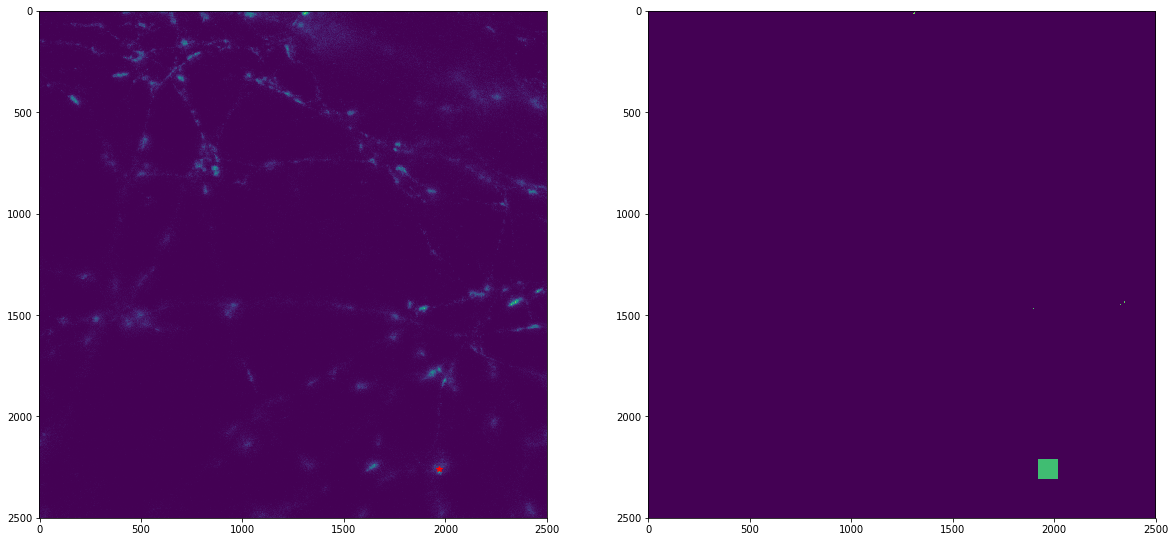

In [42]:
fig=plt.figure(figsize=(20,20))
fig.add_subplot(121)
plt.imshow(synapse_image)
plt.plot(center_of_spot[1],center_of_spot[0],'*r')
synapse_copy=deepcopy(synapse_image)
if ((center_of_spot[1]-50>0) & (center_of_spot[1]+50>0)&(center_of_spot[0]-50>0) & (center_of_spot[0]+50>0)):
    synapse_copy[center_of_spot[0]-50:center_of_spot[0]+50,
             center_of_spot[1]-50:center_of_spot[1]+50]=100
synapse_copy[synapse_copy<100]=0
fig.add_subplot(122)
plt.imshow(synapse_copy)

## Make average images

In [43]:
df=pd.DataFrame(ecm_distribution_around_synapses)

#make bins according to synapse intensity - splits from the dimmest to the brightest synapses
df["Synapse brightness scale (0 = dimmest, 7 = brightest)"]=pd.cut(df["mean_intensty_original_synapse"],bins=7,labels=np.arange(7),right=False)


### See how many synapses in each bin

In [44]:
df.groupby("Synapse brightness scale (0 = dimmest, 7 = brightest)").count()

,filename,exp condition,ecm_around_single_spot,ecm_around_single_spot_mean_intensity,original_synapse_at_single_spot,mean_intensty_original_synapse,ecm_around_single_spot bg subtracted,ecm_around_single_spot_mean_intensity bg subtracted,original_synapse_at_single_spot bg subtracted,mean_intensty_original_synapse bg subtracted,dio_around_single_spot,dio_around_single_spot_mean_intensity,dio_around_single_spot bg subtracted,dio_around_single_spot_mean_intensity bg subtracted
"Synapse brightness scale (0 = dimmest, 7 = brightest)",,,,,,,,,,,,,,
0,2658,2658,2658,2658,2658,2658,2658,2658,2658,2658,2658,2658,2658,2658
1,1161,1161,1161,1161,1161,1161,1161,1161,1161,1161,1161,1161,1161,1161
2,216,216,216,216,216,216,216,216,216,216,216,216,216,216
3,51,51,51,51,51,51,51,51,51,51,51,51,51,51
4,6,6,6,6,6,6,6,6,6,6,6,6,6,6
5,3,3,3,3,3,3,3,3,3,3,3,3,3,3
6,3,3,3,3,3,3,3,3,3,3,3,3,3,3


In [45]:
os.mkdir(expdir+protein+'_results/')
expname=filelist[i].split("/")[:-2][-1]
df.to_csv(path_or_buf=expdir+protein+'_results/results_'+str(protein)+'.csv')

In [ ]:
df=pd.read_csv(expdir+protein+'_results/results_'+str(protein)+'.csv')

## Plot a random spot image

Text(0.5, 1.0, 'dio around synapse spot bg subtracted')

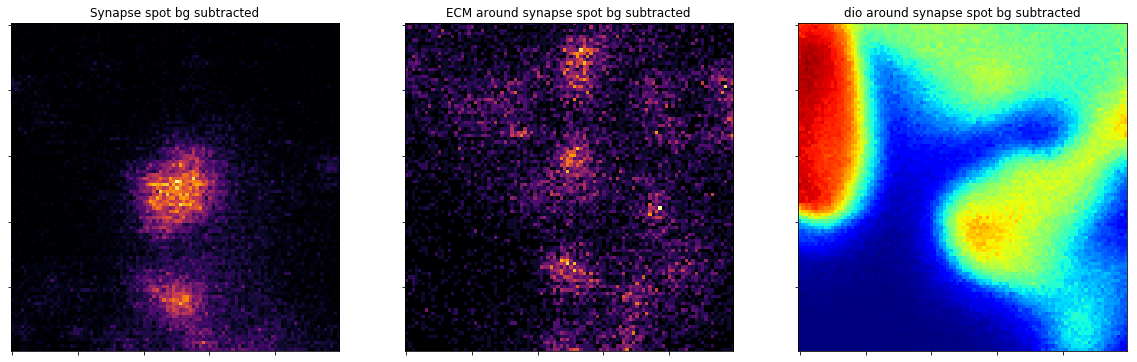

In [47]:
randomno=np.random.randint(1,len(df))


fig=plt.figure(figsize=(20,20))
fig.add_subplot(131)
plt.imshow(df["original_synapse_at_single_spot"][randomno],cmap='inferno')
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.gca().set(aspect='equal',adjustable='box')
plt.grid(False)
plt.title('Synapse spot bg subtracted')
fig.add_subplot(132)
plt.imshow(df["ecm_around_single_spot"][randomno],cmap='inferno')
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.gca().set(aspect='equal',adjustable='box')
plt.grid(False)
plt.title('ECM around synapse spot bg subtracted')
fig.add_subplot(133)
plt.imshow(df["dio_around_single_spot"][randomno],cmap='jet')
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.gca().set(aspect='equal',adjustable='box')
plt.grid(False)
plt.title('dio around synapse spot bg subtracted')

## Plots

### Define function to calculate radial average

In [48]:
## radial_average version 2
def radial_average(image):
    import numpy as np
    import scipy
    from scipy import ndimage
    import matplotlib.pyplot as plt

    f = image
    sx, sy = f.shape
    X, Y = np.ogrid[0:sx, 0:sy]


    r = np.hypot(X - sx/2, Y - sy/2)

    rbin = (20* r/r.max()).astype(np.int) ##30 rings --> r-
    radial_mean = ndimage.mean(f, labels=rbin, index=np.arange(1, rbin.max() +1))
    return radial_mean

### Analysis on first df, containing the original images (before averaging)

In [49]:
##add radial average
df['radial_average_ecm']=''
df['radial_average_ecm_bgsubtracted']=''
df['radial_average_dio']=''
df['radial_average_dio_bgsubtracted']=''

for i in range(0,len(df['radial_average_ecm_bgsubtracted'])):
    df['radial_average_ecm_bgsubtracted'][i]=radial_average(df["ecm_around_single_spot bg subtracted"][i])
    df['radial_average_ecm'][i]=radial_average(df["ecm_around_single_spot"][i])
    df['radial_average_dio_bgsubtracted'][i]=radial_average(df["dio_around_single_spot bg subtracted"][i])
    df['radial_average_dio'][i]=radial_average(df["dio_around_single_spot"][i])
    
#make df2, which also contains column names for plotting (drug, condition)
df2=deepcopy(df)
df2['Time']='None'
df2.loc[df2['exp condition'].str.contains('2hr'), 'Time'] = '2hrs'
df2.loc[df2['exp condition'].str.contains('12hrs'), 'Time'] = '12hrs'
df2.loc[df2['exp condition'].str.contains('4hrs'), 'Time'] = '4hrs'
df2.loc[df2['exp condition'].str.contains('22hrs'), 'Time'] = '22hrs'
df2.loc[df2['exp condition'].str.contains('Ctrl'), 'Time'] = 'Unblocked Control'
df2.loc[df2['exp condition'].str.contains('Bic'), 'Drug'] = 'Bic'
df2.loc[df2['exp condition'].str.contains('DMSO'), 'Drug'] = 'DMSO'
df2.loc[df2['exp condition'].str.contains('Ctrl'), 'Drug'] = 'DMSO'
#nicely written treatment condition for plotting
df2['Condition']='None'
df2.loc[df2['exp condition'].str.contains('Ctrl'), 'Condition'] = 'Unblocked Control'
df2.loc[df2['exp condition'].str.contains('2hrs_Bic'), 'Condition'] = '2hr + Bic'
df2.loc[df2['exp condition'].str.contains('2hrs_DMSO'), 'Condition'] = '2hr'
df2.loc[df2['exp condition'].str.contains('4hrs_Bic'), 'Condition'] = '4hr + Bic'
df2.loc[df2['exp condition'].str.contains('4hrs_DMSO'), 'Condition'] = '4hr'
df2.loc[df2['exp condition'].str.contains('12hrs_Bic'), 'Condition'] = '12hr + Bic'
df2.loc[df2['exp condition'].str.contains('12hrs_DMSO'), 'Condition'] = '12hr'

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/taldankovich/an

### bin according to synapse intensity - equal amount of synapses in each bin

In [54]:
##sort df2 according to synapse intensity
df2=df2.sort_values("mean_intensty_original_synapse bg subtracted",ascending=True)
df2=df2.reset_index(drop=True)
#split into 5 separate dfs, add column with number
a, b, c,d,e = np.split(df2, [int(.2*len(df2)),int(.4*len(df2)),int(.6*len(df2)),int(.8*len(df2))])
a['Synapse mean intensity ordinal bin']=0
b['Synapse mean intensity ordinal bin']=1
c['Synapse mean intensity ordinal bin']=2
d['Synapse mean intensity ordinal bin']=3
e['Synapse mean intensity ordinal bin']=4
#combine split dfs into one
df2=pd.concat([a,b,c,d,e],axis=0,ignore_index=True)

### Plot average ECM and synapse images for treated, for every synapse intensity bin

In [ ]:
df2.columns

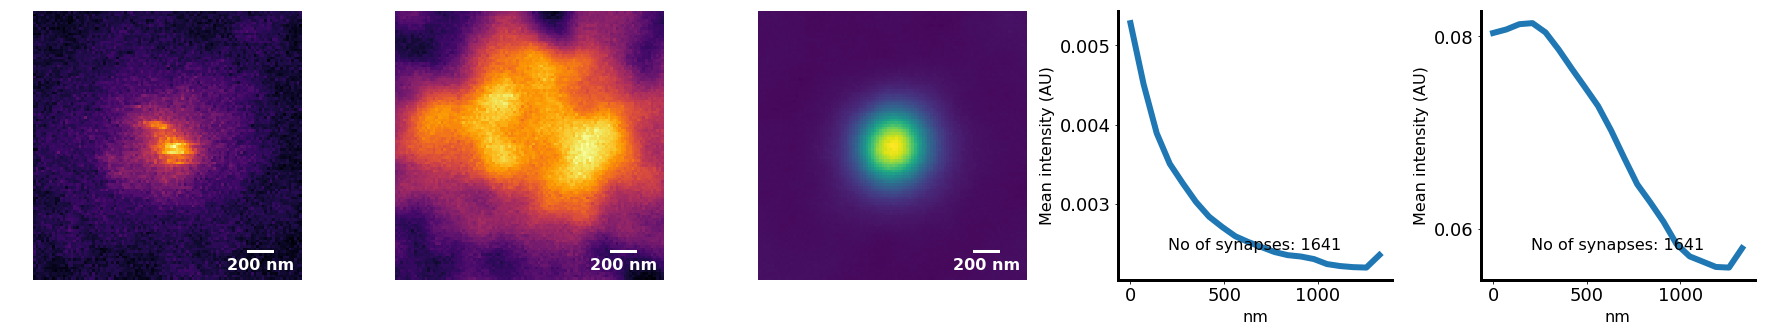

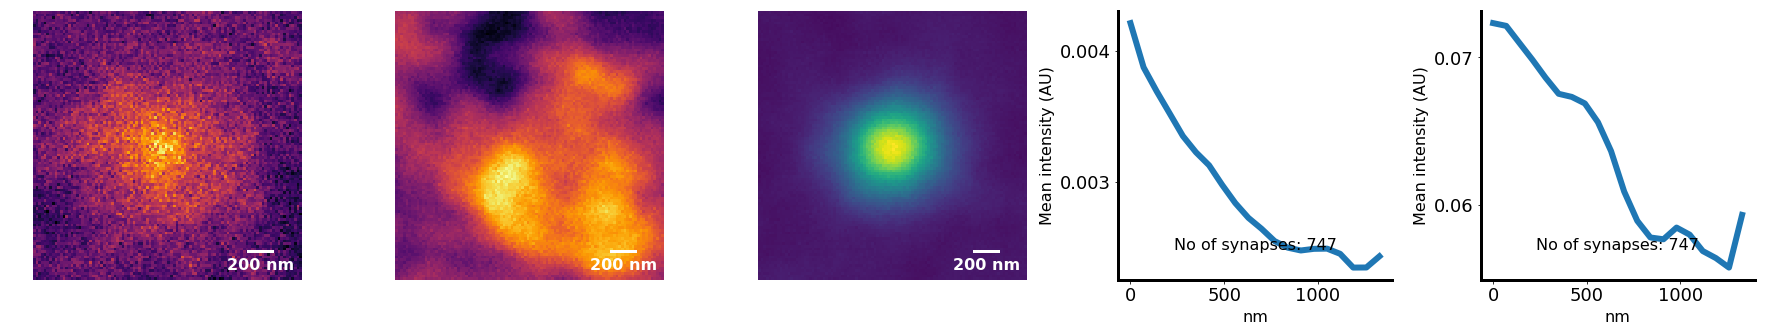

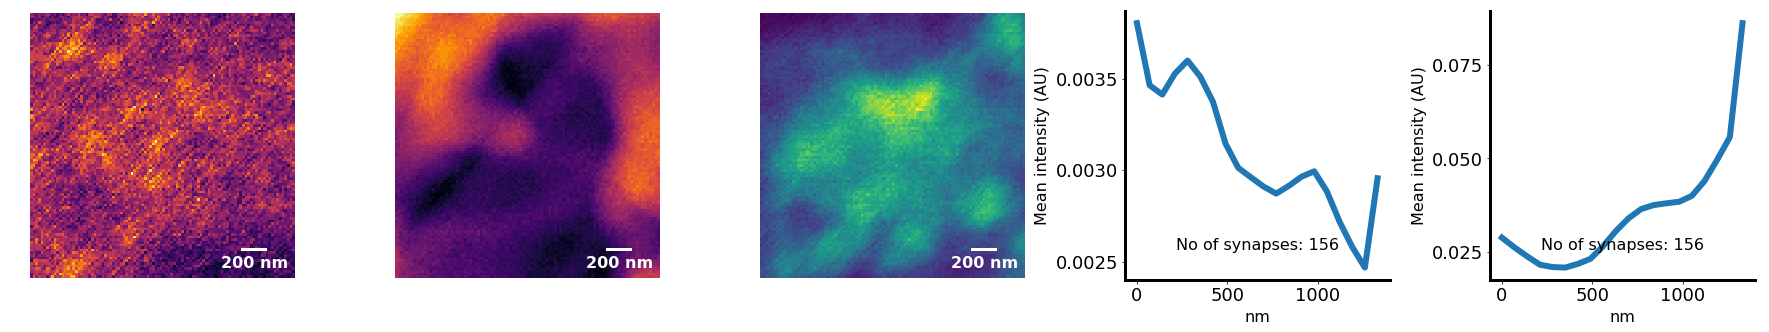

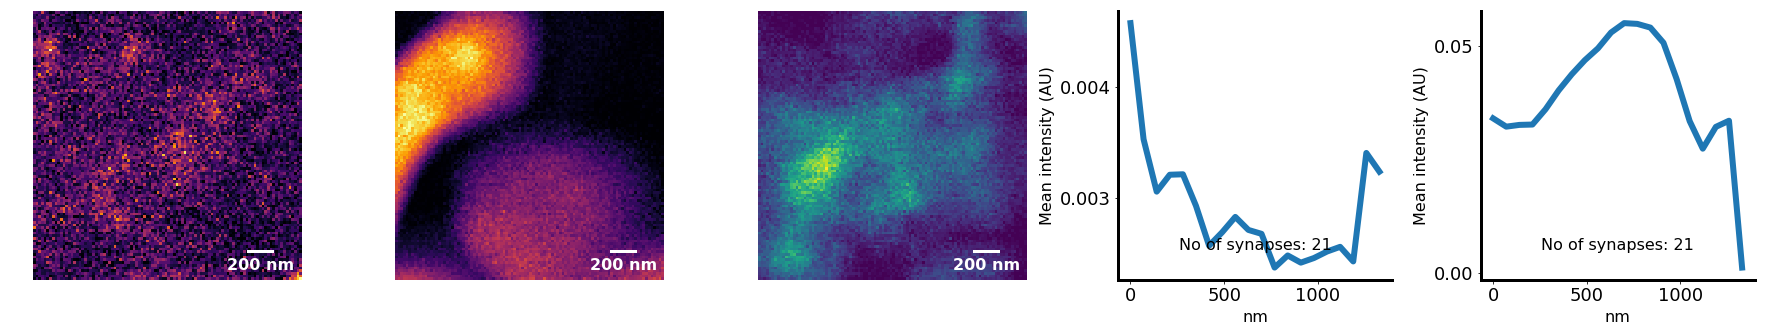

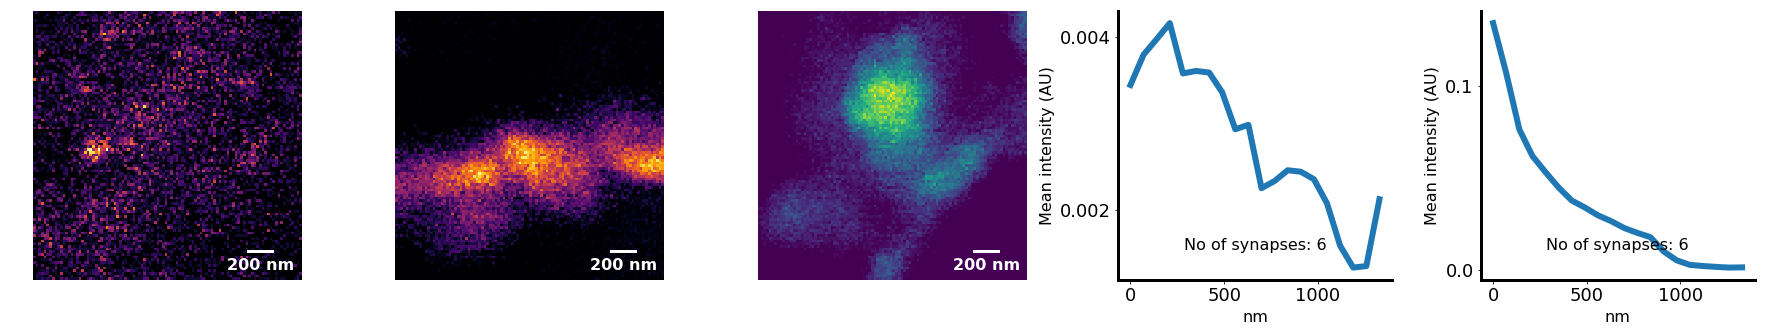

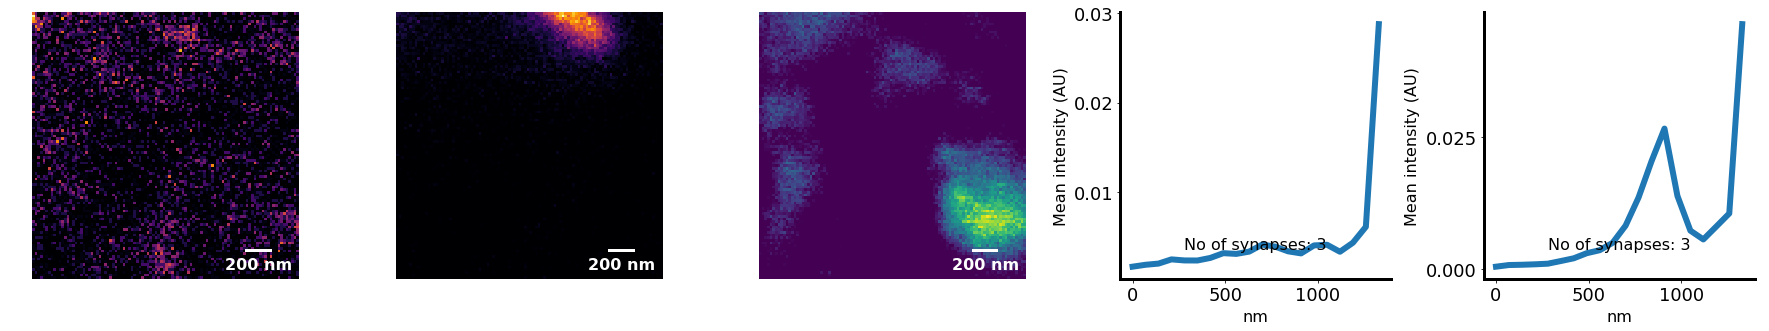

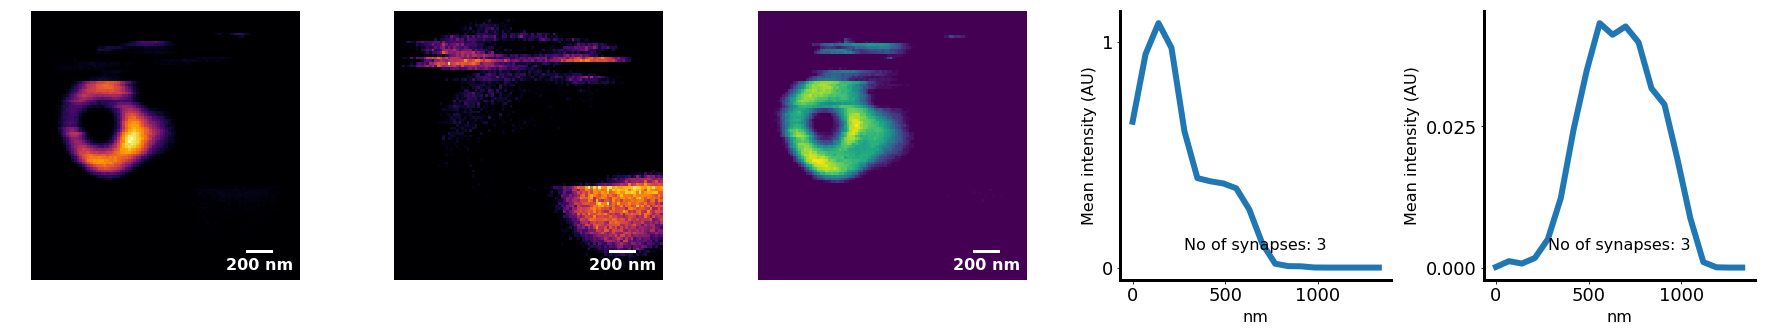

In [57]:
for i in range(7):
    df2plot=df2[(df2['Synapse brightness scale (0 = dimmest, 7 = brightest)'].astype(int)==i)&(df2["Time"]!="Unblocked Control")]
    
    fig=plt.figure(figsize=(25,5))
    plt.axis('off')
    #plt.title(str(i))
    fig.add_subplot(151)
    plt.imshow(df2plot["ecm_around_single_spot bg subtracted"].mean()
               ,cmap='inferno',
               vmin=np.min(df2plot["ecm_around_single_spot bg subtracted"].mean()),
               vmax=np.max(df2plot["ecm_around_single_spot bg subtracted"].mean()))
    scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    plt.gca().add_artist(scalebar)
    plt.axis('off')
    
    fig.add_subplot(152)
    plt.imshow(df2plot["dio_around_single_spot bg subtracted"].mean()
               ,cmap='inferno',
               vmin=np.min(df2plot["dio_around_single_spot bg subtracted"].mean()),
               vmax=np.max(df2plot["dio_around_single_spot bg subtracted"].mean()))
    scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    plt.gca().add_artist(scalebar)
    plt.axis('off')
    
    fig.add_subplot(153)
    plt.imshow(df2plot["original_synapse_at_single_spot bg subtracted"].mean(),
               cmap='viridis',
               vmin=0,#np.min(df2plot["original_synapse_at_single_spot bg subtracted"].mean()),
               vmax=np.max(df2plot["original_synapse_at_single_spot bg subtracted"].mean()))
    numbersynapses=len(df2plot["original_synapse_at_single_spot bg subtracted"])
    #plt.title('Only controls - no. synapses: '+str(numbersynapses))
    scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    plt.gca().add_artist(scalebar)
    plt.axis('off')
    
    ax=fig.add_subplot(154)
    plt.plot(np.linspace(0,70*20,num=20,endpoint=False),df2plot["radial_average_ecm_bgsubtracted"].values.mean(),linewidth=6)
    numbersynapses=len(df2plot["original_synapse_at_single_spot bg subtracted"]) 
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    #plt.ylim([0,0.02])
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    ax.text(.5,.1,'No of synapses: '+str(numbersynapses),
        horizontalalignment='center',
            verticalalignment='bottom',size=16,
        transform=ax.transAxes)
    plt.locator_params(axis='y', nbins=2)
    plt.locator_params(axis='x', nbins=5)
    plt.ylabel('Mean intensity (AU)',size=16,labelpad=5)
    plt.xlabel('nm',size=16,labelpad=5)
    #plt.subplots_adjust(right=1.2)
    
    ax=fig.add_subplot(155)
    plt.plot(np.linspace(0,70*20,num=20,endpoint=False),df2plot["radial_average_dio_bgsubtracted"].values.mean(),linewidth=6)
    numbersynapses=len(df2plot["original_synapse_at_single_spot bg subtracted"]) 
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    #plt.ylim([0.0025,0.004])
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    ax.text(.5,.1,'No of synapses: '+str(numbersynapses),
        horizontalalignment='center',
            verticalalignment='bottom',size=16,
        transform=ax.transAxes)
    plt.locator_params(axis='y', nbins=2)
    plt.locator_params(axis='x', nbins=5)
    plt.ylabel('Mean intensity (AU)',size=16,labelpad=5)
    plt.xlabel('nm',size=16,labelpad=5)
    #plt.subplots_adjust(right=1.2)
    plt.tight_layout()

### Look at several examples of synapse spots for treated conditions

In [51]:
df2plot_noctrl=df2[(df2["Time"]!="Unblocked Control")]
df2plot_noctrl=df2plot_noctrl.reset_index()

In [ ]:
for i in range(0,20):
    fig=plt.figure(figsize=(4,2))
    #fig.add_subplot(121)
    plt.imshow(df2plot_noctrl["original_synapse_at_single_spot"][i],
               cmap='viridis'
               ,vmin=1.00*df2plot_noctrl["original_synapse_at_single_spot"][10].min(),
               vmax=0.999*df2plot_noctrl["original_synapse_at_single_spot"][10].max())
    #fig.add_subplot(122)
    #plt.imshow(df2plot_noctrl["original_synapse_at_single_spot"][i],
     #         cmap='viridis',vmin=1.00*average_imagebsynapse.min(),vmax=0.999*average_imagebsynapse.max())

### Look at several examples of synapse and ecm spots for unblocked controls

In [ ]:
np.min((df2plot["original_synapse_at_single_spot bg subtracted"].mean()))

In [ ]:
df2plot=df2
df2plot=df2plot.reset_index()

In [ ]:
from matplotlib_scalebar.scalebar import ScaleBar
for i in range(0,10):
    fig=plt.figure(figsize=(12,3))
    fig.add_subplot(131)
    plt.imshow(df2plot["original_synapse_at_single_spot bg subtracted"][i],cmap='viridis',
              vmin=0.9*np.min((df2["original_synapse_at_single_spot bg subtracted"].mean())),
              vmax=0.9*np.max((df2["original_synapse_at_single_spot bg subtracted"].mean())))
    scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    plt.gca().add_artist(scalebar)
    plt.axis('off')
    fig.add_subplot(132)
    plt.imshow(df2plot["ecm_around_single_spot bg subtracted"][i],cmap='hot',
              vmin=0.5*np.min(df2["ecm_around_single_spot bg subtracted"].mean()),
              vmax=10*np.max(df2["ecm_around_single_spot bg subtracted"].mean()))
    scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    plt.gca().add_artist(scalebar)
    plt.axis('off')
    fig.add_subplot(133)
    plt.imshow(df2plot["funcat_around_single_spot bg subtracted"][i],cmap='hot',
              vmin=0.5*np.min(df2["funcat_around_single_spot bg subtracted"].mean()),
              vmax=5*np.max(df2["funcat_around_single_spot bg subtracted"].mean()))
    scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    plt.gca().add_artist(scalebar)
    plt.axis('off')

### Plot all treated and all unblocked controls  - Bic versus DMSO

KeyError: 'radial_average_bgsubtracted'

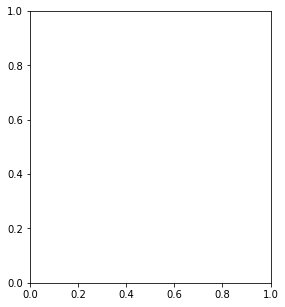

In [53]:
i=-1
df2plot=df2[(df2['Synapse brightness scale (0 = dimmest, 7 = brightest)'].astype(int)>i)&(df2["Time"]!="Unblocked Control")]

bic=df2plot[(df2plot["Drug"]=="Bic")]
dmso=df2plot[(df2plot["Drug"]=="DMSO")]

fig=plt.figure(figsize=(25,5))
fig.add_subplot(151)
plt.plot(dmso["radial_average_bgsubtracted"].values.mean(),linewidth=6.0,color='blue')
plt.plot(bic["radial_average_bgsubtracted"].mean(),linewidth=6.0,color='red')
plt.gca().set(adjustable='box')
plt.legend(['DMSO','Bic'],fontsize=24)
fig.add_subplot(152)
average_imageb=sum(dmso["ecm_around_single_spot bg subtracted"])/len(dmso["ecm_around_single_spot"])
plt.imshow(average_imageb,cmap='inferno',vmin=1.05*average_imageb.min(),vmax=0.95*average_imageb.max())

fig.add_subplot(153)
average_imagebsynapse=sum(dmso["original_synapse_at_single_spot bg subtracted"])/len(dmso["original_synapse_at_single_spot bg subtracted"])
plt.imshow(average_imagebsynapse,cmap='viridis',vmin=1.00*average_imagebsynapse.min(),vmax=0.8*average_imagebsynapse.max())
plt.title('DMSO')

fig.add_subplot(154)
average_imagec=sum(bic["ecm_around_single_spot bg subtracted"])/len(bic["ecm_around_single_spot"])
plt.imshow(average_imagec,cmap='inferno',vmin=1.05*average_imageb.min(),vmax=0.95*average_imageb.max())

fig.add_subplot(155)
average_imagebsynapseb=sum(bic["original_synapse_at_single_spot bg subtracted"])/len(bic["original_synapse_at_single_spot bg subtracted"])
plt.imshow(average_imagebsynapseb,cmap='viridis',vmin=1.00*average_imagebsynapse.min(),vmax=0.999*average_imagebsynapse.max())
plt.title('Bic')

###plot only control
df2plot_ctrl=df2[(df2['Synapse brightness scale (0 = dimmest, 7 = brightest)'].astype(int)>i)&(df2["Time"]=="Unblocked Control")]

fig=plt.figure(figsize=(25,5))
fig.add_subplot(131)
plt.plot(df2plot_ctrl["radial_average_bgsubtracted"].values.mean(),linewidth=6.0,color='blue')
plt.gca().set(adjustable='box')
plt.legend(['Ctrls unblocked'],fontsize=24)
fig.add_subplot(132)
average_imageb=sum(df2plot_ctrl["ecm_around_single_spot bg subtracted"])/len(df2plot_ctrl["ecm_around_single_spot"])
plt.imshow(average_imageb,cmap='inferno',vmin=1.05*average_imageb.min(),vmax=0.95*average_imageb.max())
fig.add_subplot(133)
average_imagebsynapseb=sum(df2plot_ctrl["original_synapse_at_single_spot bg subtracted"])/len(df2plot_ctrl["original_synapse_at_single_spot bg subtracted"])
plt.imshow(average_imagebsynapseb,cmap='viridis',vmin=1.00*average_imagebsynapse.min(),vmax=0.999*average_imagebsynapse.max())


KeyError: 'radial_average_bgsubtracted'

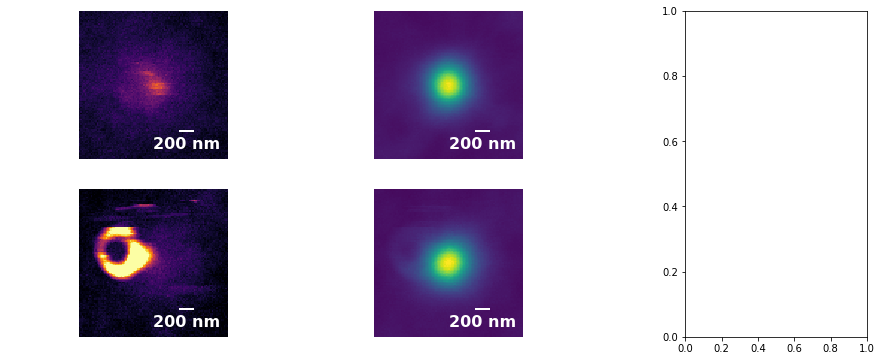

In [52]:
df2plot=df2[df2["Time"]!="Unblocked Control"]
df2plotcontrols=df2[df2["Time"]=="Unblocked Control"]
df2plot_bic=df2plot[df2plot["Drug"]=="Bic"]
df2plot_dmso=df2plot[df2plot["Drug"]=="DMSO"]
#load control images§a


fig=plt.figure(figsize=(15,6))
plt.axis('off')
#plt.title(str(i))
fig.add_subplot(231)
plt.imshow(df2plot_dmso["ecm_around_single_spot bg subtracted"].mean()
           ,cmap='inferno',
           vmin=np.min(df2plot["ecm_around_single_spot bg subtracted"].mean()),
           vmax=np.max(df2plot["ecm_around_single_spot bg subtracted"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
plt.ylabel('DMSO',size=18,weight='bold')
plt.axis('off')
fig.add_subplot(232)
plt.imshow(df2plot_dmso["original_synapse_at_single_spot bg subtracted"].mean(),
           cmap='viridis',
           vmin=0,#np.min(df2plot["original_synapse_at_single_spot bg subtracted"].mean()),
           vmax=np.max(df2plot["original_synapse_at_single_spot bg subtracted"].mean()))
numbersynapses=len(df2plot_dmso["original_synapse_at_single_spot bg subtracted"])
#plt.title('Only controls - no. synapses: '+str(numbersynapses))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
plt.axis('off')

plt.axis('off')
#plt.title(str(i))
fig.add_subplot(234)
plt.imshow(df2plot_bic["ecm_around_single_spot bg subtracted"].mean()
           ,cmap='inferno',
           vmin=np.min(df2plot["ecm_around_single_spot bg subtracted"].mean()),
           vmax=np.max(df2plot["ecm_around_single_spot bg subtracted"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
plt.ylabel('Bic',size=18,weight='bold')

plt.axis('off')
fig.add_subplot(235)
plt.imshow(df2plot_bic["original_synapse_at_single_spot bg subtracted"].mean(),
           cmap='viridis',
           vmin=0,#np.min(df2plot["original_synapse_at_single_spot bg subtracted"].mean()),
           vmax=np.max(df2plot["original_synapse_at_single_spot bg subtracted"].mean()))
numbersynapses=len(df2plot_bic["original_synapse_at_single_spot bg subtracted"])
#plt.title('Only controls - no. synapses: '+str(numbersynapses))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
plt.axis('off')

ax=fig.add_subplot(144)
plt.plot(np.linspace(0,70*20,num=20,endpoint=False),df2plot_dmso["radial_average_bgsubtracted"].values.mean(),
         linewidth=6,color='lightgreen',alpha=.8)
plt.plot(np.linspace(0,70*20,num=20,endpoint=False),df2plot_bic["radial_average_bgsubtracted"].values.mean(),
         linewidth=6,color='mediumpurple',alpha=.8)


numbersynapses=len(df2plot["original_synapse_at_single_spot bg subtracted"]) 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
#plt.ylim([0.0025,0.004])
plt.xticks(size = 18)
plt.yticks(size = 18)
#ax.text(.5,.1,'No of synapses: '+str(numbersynapses),horizontalalignment='center',verticalalignment='bottom',size=16,transform=ax.transAxes)
plt.locator_params(axis='y', nbins=2)
plt.locator_params(axis='x', nbins=5)
plt.ylabel('Mean intensity (AU)',size=16,labelpad=5)
plt.xlabel('nm',size=16,labelpad=5)
plt.legend(['DMSO','Bic'],frameon=False,fontsize=16,loc=0)
#plt.subplots_adjust(right=1.2)
#plt.tight_layout()

## plot dmso versus bic at different timepoints

In [ ]:
time="12hrs"

df2plot=df2[df2["Time"]==time]
df2plotcontrols=df2[df2["Time"]=="Unblocked Control"]
df2plot_bic=df2plot[df2plot["Drug"]=="Bic"]
df2plot_dmso=df2plot[df2plot["Drug"]=="DMSO"]
#load control images§a


fig=plt.figure(figsize=(15,6))
plt.axis('off')
#plt.title(str(i))
fig.add_subplot(231)
plt.imshow(df2plot_dmso["ecm_around_single_spot bg subtracted"].mean()
           ,cmap='inferno',
           vmin=np.min(df2plot["ecm_around_single_spot bg subtracted"].mean()),
           vmax=np.max(df2plot["ecm_around_single_spot bg subtracted"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
plt.ylabel('DMSO',size=18,weight='bold')
plt.axis('off')
fig.add_subplot(232)
plt.imshow(df2plot_dmso["original_synapse_at_single_spot bg subtracted"].mean(),
           cmap='viridis',
           vmin=0,#np.min(df2plot["original_synapse_at_single_spot bg subtracted"].mean()),
           vmax=np.max(df2plot["original_synapse_at_single_spot bg subtracted"].mean()))
numbersynapses=len(df2plot_dmso["original_synapse_at_single_spot bg subtracted"])
#plt.title('Only controls - no. synapses: '+str(numbersynapses))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
plt.axis('off')

plt.axis('off')
#plt.title(str(i))
fig.add_subplot(234)
plt.imshow(df2plot_bic["ecm_around_single_spot bg subtracted"].mean()
           ,cmap='inferno',
           vmin=np.min(df2plot["ecm_around_single_spot bg subtracted"].mean()),
           vmax=np.max(df2plot["ecm_around_single_spot bg subtracted"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
plt.ylabel('Bic',size=18,weight='bold')

plt.axis('off')
fig.add_subplot(235)
plt.imshow(df2plot_bic["original_synapse_at_single_spot bg subtracted"].mean(),
           cmap='viridis',
           vmin=0,#np.min(df2plot["original_synapse_at_single_spot bg subtracted"].mean()),
           vmax=np.max(df2plot["original_synapse_at_single_spot bg subtracted"].mean()))
numbersynapses=len(df2plot_bic["original_synapse_at_single_spot bg subtracted"])
#plt.title('Only controls - no. synapses: '+str(numbersynapses))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
plt.axis('off')

ax=fig.add_subplot(144)
plt.plot(np.linspace(0,70*20,num=20,endpoint=False),df2plot_dmso["radial_average_bgsubtracted"].values.mean(),
         linewidth=6,color='lightgreen',alpha=.8)
plt.plot(np.linspace(0,70*20,num=20,endpoint=False),df2plot_bic["radial_average_bgsubtracted"].values.mean(),
         linewidth=6,color='mediumpurple',alpha=.8)


numbersynapses=len(df2plot["original_synapse_at_single_spot bg subtracted"]) 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
#plt.ylim([0.0025,0.004])
plt.xticks(size = 18)
plt.yticks(size = 18)
#ax.text(.5,.1,'No of synapses: '+str(numbersynapses),horizontalalignment='center',verticalalignment='bottom',size=16,transform=ax.transAxes)
plt.locator_params(axis='y', nbins=2)
plt.locator_params(axis='x', nbins=5)
plt.ylabel('Mean intensity (AU)',size=16,labelpad=5)
plt.xlabel('nm',size=16,labelpad=5)
plt.legend(['DMSO','Bic'],frameon=False,fontsize=16,loc=0)
#plt.subplots_adjust(right=1.2)
#plt.tight_layout()

In [ ]:
i=-1
df2plot=df2[(df2['Synapse brightness scale (0 = dimmest, 7 = brightest)'].astype(int)>i)&(df2["Time"]!="Unblocked Control")]
for time in df2plot["Time"].unique():
    bic=df2plot[(df2plot["Drug"]=="Bic")&(df2plot["Time"]==time)]
    dmso=df2plot[(df2plot["Drug"]=="DMSO")&(df2plot["Time"]==time)]
    
    fig=plt.figure(figsize=(25,5))
    fig.add_subplot(151)
    plt.title(str(time)+str(len(df2plot[df2plot["Time"]==time])))
    plt.plot(np.linspace(0,70*20,num=20,endpoint=False),dmso["radial_average_bgsubtracted"].values.mean(),
        linewidth=6.0,color='blue')
    plt.plot(np.linspace(0,70*20,num=20,endpoint=False),bic["radial_average_bgsubtracted"].values.mean(),
             linewidth=6.0,color='red')
    plt.gca().set(adjustable='box')
    #plt.xlim([0,2000])
    plt.legend(['DMSO','Bic'],fontsize=24)
    
    fig.add_subplot(152)
    average_imageb=sum(dmso["ecm_around_single_spot bg subtracted"])/len(dmso["ecm_around_single_spot"])
    plt.imshow(average_imageb,cmap='inferno',vmin=1.05*average_imageb.min(),vmax=0.95*average_imageb.max())
    
    fig.add_subplot(153)
    average_imagebsynapse=sum(dmso["original_synapse_at_single_spot bg subtracted"])/len(dmso["original_synapse_at_single_spot bg subtracted"])
    plt.imshow(average_imagebsynapse,cmap='viridis',vmin=1.00*average_imagebsynapse.min(),vmax=0.999*average_imagebsynapse.max())
    plt.title('DMSO')
    
    fig.add_subplot(154)
    average_imagec=sum(bic["ecm_around_single_spot bg subtracted"])/len(bic["ecm_around_single_spot"])
    plt.imshow(average_imagec,cmap='inferno',vmin=1.05*average_imageb.min(),vmax=0.95*average_imageb.max())
    
    fig.add_subplot(155)
    average_imagebsynapseb=sum(bic["original_synapse_at_single_spot bg subtracted"])/len(bic["original_synapse_at_single_spot bg subtracted"])
    plt.imshow(average_imagebsynapseb,cmap='viridis',vmin=1.00*average_imagebsynapse.min(),vmax=0.999*average_imagebsynapse.max())
    plt.title('Bic')
    

### Plot Bic/DMSO at different timepoints, separate for synapse intensity bins

In [ ]:
for i in range(7):
    df2plot=df2[(df2['Synapse brightness scale (0 = dimmest, 7 = brightest)'].astype(int)==i)&(df2["Time"]!="Unblocked Control")]
    for time in df2plot["Time"].unique():
        bic=df2plot[(df2plot["Drug"]=="Bic")&(df2plot["Time"]==time)]
        dmso=df2plot[(df2plot["Drug"]=="DMSO")&(df2plot["Time"]==time)]

        fig=plt.figure(figsize=(25,5))
        fig.add_subplot(151)
        plt.title(str(time)+str(len(df2plot[df2plot["Time"]==time])))
        plt.plot(np.linspace(0,70*20,num=20,endpoint=False),dmso["radial_average_bgsubtracted"].values.mean(),
            linewidth=6.0,color='blue')
        plt.plot(np.linspace(0,70*20,num=20,endpoint=False),bic["radial_average_bgsubtracted"].values.mean(),
                 linewidth=6.0,color='red')
        plt.gca().set(adjustable='box')
        #plt.xlim([0,2000])
        plt.legend(['DMSO','Bic'],fontsize=24)

        fig.add_subplot(152)
        average_imageb=sum(dmso["ecm_around_single_spot bg subtracted"])/len(dmso["ecm_around_single_spot"])
        plt.imshow(average_imageb,cmap='inferno',vmin=1.05*average_imageb.min(),vmax=0.95*average_imageb.max())

        fig.add_subplot(153)
        average_imagebsynapse=sum(dmso["original_synapse_at_single_spot bg subtracted"])/len(dmso["original_synapse_at_single_spot bg subtracted"])
        plt.imshow(average_imagebsynapse,cmap='viridis',vmin=1.00*average_imagebsynapse.min(),vmax=0.999*average_imagebsynapse.max())
        plt.title('DMSO')

        fig.add_subplot(154)
        average_imagec=sum(bic["ecm_around_single_spot bg subtracted"])/len(bic["ecm_around_single_spot"])
        plt.imshow(average_imagec,cmap='inferno',vmin=1.05*average_imageb.min(),vmax=0.95*average_imageb.max())

        fig.add_subplot(155)
        average_imagebsynapseb=sum(bic["original_synapse_at_single_spot bg subtracted"])/len(bic["original_synapse_at_single_spot bg subtracted"])
        plt.imshow(average_imagebsynapseb,cmap='viridis',vmin=1.00*average_imagebsynapse.min(),vmax=0.999*average_imagebsynapse.max())
        plt.title('Bic')  

### compare intensities between conditions - synapses and ecm

In [ ]:
df2.columns

In [ ]:
import seaborn as sns
d=df2[df2["exp condition"]!="Ctrl_NoBlocking"]
order=['2hrs_DMSO','2hrs_Bic','4hrs_DMSO','4hrs_Bic','12hrs_DMSO','12hrs_Bic']
plt.figure(figsize=(20,10))
sns.barplot(x="exp condition",y='ecm_around_single_spot_mean_intensity bg subtracted',data=d,order=order)

In [ ]:
df2.columns

In [ ]:
df2plotscat=df2
sns.set_palette("husl")
plt.figure(figsize=(10,10))
#df2.plot(x='ecm_around_single_spot_mean_intensity bg subtracted',y='mean_intensty_original_synapse bg subtracted',
         #loglog=True,kind='scatter',)
ax=sns.scatterplot(x='ecm_around_single_spot_mean_intensity bg subtracted',y='funcat_around_single_spot_mean_intensity bg subtracted',
                  data=df2plotscat)
#ax.set(xscale="log", yscale="log")
ax.set(yscale="log")
#ax.set_xlim([0,0.01])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
#plt.ylim([0.0025,0.004])
plt.xticks(size = 18)
plt.yticks(size = 18)
#ax.text(.5,.1,'No of synapses: '+str(numbersynapses),horizontalalignment='center',verticalalignment='bottom',size=16,transform=ax.transAxes)
#plt.locator_params(axis='y', nbins=5)
#plt.locator_params(axis='x', nbins=5)
plt.ylabel('Mean intensity Synapse (AU)',size=16,labelpad=5)
plt.xlabel('Mean intensity ECM (AU)',size=16,labelpad=5)
plt.legend(frameon=False,fontsize=16,loc=0)

In [ ]:
df2plotscat=df2[df2["Time"]=="12hrs"]
sns.set_palette("husl")
plt.figure(figsize=(10,10))
#df2.plot(x='ecm_around_single_spot_mean_intensity bg subtracted',y='mean_intensty_original_synapse bg subtracted',
         #loglog=True,kind='scatter',)
ax=sns.scatterplot(x='ecm_around_single_spot_mean_intensity bg subtracted',y='mean_intensty_original_synapse bg subtracted',
                  data=df2plotscat,hue='Drug',palette=['lightgreen','mediumpurple']
                   ,alpha=0.7)

from matplotlib import pylab
# Scientific libraries
import numpy as np
from scipy.optimize import curve_fit
from lmfit import minimize, Parameters, Parameter, report_fit

x = df2plotscat["ecm_around_single_spot_mean_intensity bg subtracted"]
y = df2plotscat["mean_intensty_original_synapse bg subtracted"]

def exponenial_func(x, a, b, c):
    return a*np.exp(-b*x)+c
###############################################

def func2(params, x, data):

    m = params['m'].value
    c = params['c'].value
    d = params['d'].value

    model = np.power(x,m)*c + d
    return model - data #that's what you want to minimize

# create a set of Parameters
params = Parameters()
params.add('m', value= -2) #value is the initial condition
params.add('c', value= 8.)
params.add('d', value= 10.0, min=0) #min=0 prevents that d becomes negative

# do fit, here with leastsq model
#result = minimize(func2, params, args=(x, y))

#final = y + result.residual

###############################################

popt, pcov = curve_fit(exponenial_func, x, y,bounds=[0,0.01])
#popt,pcov=curve_fit(Ebfit,x,y)


xx = np.linspace(0,0.01)
yy = exponenial_func(x, *popt)
#plt.plot(x,yy,'r')

#plt.plot(x,final,'r')

#ax.set(xscale="log", yscale="log")
#ax.set(yscale="log")
ax.set_xlim([0,0.01])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
#plt.ylim([0.0025,0.004])
plt.xticks(size = 18)
plt.yticks(size = 18)
#ax.text(.5,.1,'No of synapses: '+str(numbersynapses),horizontalalignment='center',verticalalignment='bottom',size=16,transform=ax.transAxes)
plt.locator_params(axis='y', nbins=5)
plt.locator_params(axis='x', nbins=5)
plt.ylabel('Mean intensity Synapse (AU)',size=16,labelpad=5)
plt.xlabel('Mean intensity ECM (AU)',size=16,labelpad=5)
plt.legend(frameon=False,fontsize=16,loc=0)


In [ ]:
y

## browse individual images

In [ ]:
df2ploty["original_synapse_at_single_spot bg subtracted"][0].mean()

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact



def f(Image_no,Synapse_Intensity_bin):
    
    df2ploty=df2[df2['Synapse mean intensity ordinal bin']==int(Synapse_Intensity_bin)]
    df2ploty=df2ploty.reset_index()
    ii=Image_no
    fig=plt.figure(figsize=(8,4))
    fig.add_subplot(121)
    plt.imshow(df2ploty["ecm_around_single_spot bg subtracted"][ii],
               cmap='inferno'
               ,vmin=1.00*df2ploty["ecm_around_single_spot bg subtracted"][10].min(),
               vmax=0.999*df2ploty["ecm_around_single_spot bg subtracted"][10].max())
    fig.add_subplot(122)
    plt.imshow(df2ploty["original_synapse_at_single_spot bg subtracted"][ii],
               cmap='viridis',vmin=0,vmax=0.03)
               #,vmin=0*df2ploty["original_synapse_at_single_spot bg subtracted"][100].min(),
               #vmax=3*df2ploty["original_synapse_at_single_spot bg subtracted"][100].max())
    

#widgets

Image_no=widgets.IntText(min=0,max=len(df2plot),value=1)
Synapse_Intensity_bin=widgets.IntText(min=0,max=4,value=0)

w=interact(f,Image_no=Image_no,Synapse_Intensity_bin=Synapse_Intensity_bin)





In [ ]:
df3=df2[df2['Synapse mean intensity ordinal bin']==int(1)]
df3.head()

In [ ]:
import seaborn as sns
import plotly.plotly as py #For World Map
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering

import os                     # For os related operations
import sys  

In [ ]:
df_means=df[[yvar,xvar]]
#K means Clustering 
def doKmeans(X, nclust=3):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)

clust_labels, cent = doKmeans(df_means, 3)
kmeans = pd.DataFrame(clust_labels)
df_means.insert((df_means.shape[1]),'kmeans',kmeans)

In [ ]:
#Plot the clusters obtained using k means
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(df_means[yvar],df_means[xvar],
                     c=kmeans[0],s=50)
ax.set_title('K-Means Clustering')
ax.set_xlabel('ECM')
ax.set_ylabel('Synapses')

plt.colorbar(scatter)

## image for presenting

In [ ]:
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
nuclei_channel_no=results["nucleichannelno"][randomno]
synapse_channel_no=results["synapsechannelno"][randomno]

ecm_image_name=results["filename"][randomno]+" Ch"+str(ecm_channel_no)+" {0}.tif"
nuclei_image_name=results["filename"][randomno]+" Ch"+str(nuclei_channel_no)+" {0}.tif"
synapse_image_name=results["filename"][randomno]+" Ch"+str(synapse_channel_no)+" {0}.tif"


print("Image name:",results["filename"][randomno].split('/')[-1])
print("Experimental condition:",results["exp condition"][randomno])
ecm_image=pims.open(ecm_image_name)[0]
nuclei_image=pims.open(nuclei_image_name)[0]
synapse_image=pims.open(synapse_image_name)[0]

figure=plt.figure(figsize=(15,15))
figure.add_subplot(121)
plt.imshow(ecm_image,interpolation='none',cmap='hot',vmin=3*np.min(ecm_image),vmax=0.4*np.max(ecm_image))
plt.title('Tenascin-R (STED)')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
figure.add_subplot(122)
plt.imshow(synapse_image,interpolation='none',cmap='inferno')
plt.title('Synaptotagmin-1')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)




### look at distance of tnr from nearest dapi edge

### load tnr spots masks made by icy wavelet transform

In [ ]:
results["TNR spots mask"]=[]
for i in range(0,len(results["filename"])):
    results["TNR spots mask"].append(np.nan)
for mask in range(0,len(results["filename"])):
    print(results["filename"][mask])
    file_name='/'.join(results["filename"][mask].split('/')[:-1])+'/save/'+results["filename"][mask].split('/')[-1]+' Ch1 {0}.tif.roi.binary.tif'
    tnrmask=pims.open(file_name)[0]
    results["TNR spots mask"][mask]=tnrmask

### calculate mean distance from dapi for each spot:
- for each image:
    - load dapi image, clean and binarize it
    - load tnr spots mask from icy
        - label it 
        - regionprops to find centroids of spots
        - for each spot:
            - find centroid
            - calculate min distance from dapi image
            - append to a new dictionary with spots

In [ ]:
range(0,len[results["filename"]])

In [ ]:
tnr_spots={'filename':[],'exp condition':[],'min distance to dapi edge':[]}
from scipy.spatial import distance
#iterate over images
for im in range(0,len(results["filename"])):
    #load dapi image
    nuclei_channel_no=results["nucleichannelno"][im]
    nuclei_image_name=results["filename"][im]+" Ch"+str(nuclei_channel_no)+" {0}.tif"
    nuclei_image=pims.open(nuclei_image_name)[0]
    # clean and binarize dapi image
    nuclei_image=nuclei_image=ndi.gaussian_filter(nuclei_image,sigma=10)
    nuclei_threshold=skimage.filters.threshold_otsu(nuclei_image)
    nuclei_mask=nuclei_image>nuclei_threshold
    nuclei_mask=ndi.binary_dilation(nuclei_mask,iterations=20)
    nuclei_mask=ndi.binary_erosion(nuclei_mask,iterations=20)
    nuclei_mask=ndi.binary_fill_holes(nuclei_mask)
    #find coordinates of nuclei_mask where it equals 1
    a=np.where(nuclei_mask == 1)
    coordinates_nuclei=np.zeros([len(a[0]),2])
    for i in range(0,len(a[0])):
        coordinates_nuclei[i][0]=a[0][i]
        coordinates_nuclei[i][1]=a[1][i]
    #load tnr spots mask
    tnrmask=results["TNR spots mask"][im]
    #for each spot in tnr mask - find minimum distance to dapi mask
    tnr_labelled,ccnum=ndi.label(tnrmask)
    regions = regionprops(tnr_labelled)
    for props in regions:
        y0, x0 = props.centroid
        X = [(y0, x0)]
        coords = coordinates_nuclei
        mindist=distance.cdist(X, coords, 'euclidean')
        tnr_spots['filename'].append(results["filename"][im])
        tnr_spots["exp condition"].append(results["exp condition"][im])
        tnr_spots["min distance to dapi edge"].append(mindist)

In [ ]:
tnrmask=results["TNR spots mask"][0]
#tnrmask=tnrmask>0
fig=plt.figure(figsize=(12,4))
fig.add_subplot(131)
plt.imshow(ecm_image)
fig.add_subplot(132)
plt.imshow(tnrmask,cmap='gray',interpolation='none')
fig.add_subplot(133)
plt.imshow(nuclei_image)
tnr_labelled,ccnum=ndi.label(tnrmask)